In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# SWIFT PAT+OBS: Produce figures 10-11

## I/O data

In [2]:
simulations = {
    'case A0': 'internal.ipa.obs.noT',
    'case Bn': 'internal.dpa.obs.allT',
    'case B1': 'internal.dpa.obs.Tassim',
    'case B0': 'internal.dpa.obs.noT',
}

In [3]:
datadir = '/scratch/dallaert/profile_assimilation_obs'

In [4]:
save_figures = False
figname_prefix = 'results_B'

## Some definitions

In [5]:
hub_height = 90

In [6]:
# LOCAL times, from https://www.timeanddate.com/sun/usa/lubbock?month=11&year=2013
sunrise = '2013-11-08 07:12'
sunset  = '2013-11-08 17:49'

In [7]:
tower_10min_data_file = 'TTU_tilt_corrected_20131108-09_10min.csv'
rass_data_file = 'combined_radar_met_sounding_QC.csv'
radar_data_file = 'TTU_obs_QC_20131108.csv'

## Prepare environment

In [8]:
import os
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [9]:
# Manually adding path to mmctools repository to PYTHONPATH
sys.path.append(os.path.join(os.environ['HOME'],'tools','a2e-mmc'))

from mmctools.mmctools.plotting import plot_timehistory_at_height, plot_profile

In [10]:
from helper_functions import sim_style, my_fieldlabels

In [11]:
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize']  = 16
mpl.rcParams['axes.titlesize']  = 16

## Load simulation data

In [12]:
from helper_functions import calc_QOIs

Load simulation data

In [13]:
%%time
df_10min = {}
for name,sim in simulations.items():
    print('Processing '+name)
    # Read 10min data
    df_10min[name] = xr.open_dataset(os.path.join(datadir,sim,'probe1_10min.nc')).to_dataframe()
    # Calculate some quantities of interest
    calc_QOIs(df_10min[name])

Processing case A0
Processing case Bn
Processing case B1
Processing case B0
CPU times: user 2.75 s, sys: 49.1 ms, total: 2.8 s
Wall time: 2.94 s


Calculate hourly averaged data

In [14]:
df_1h = {}
for sim in simulations:
    df_1h[sim] = df_10min[sim].unstack().resample('1h').mean().stack()

## Load reference data

Reference data:
- **TTU tower (10-min statistics):** Data from the TTU meteorological tower. Dataset generated in [process_TTU_tower.ipynb](https://github.com/a2e-mmc/assessment/blob/master/datasets/SWiFT/process_TTU_tower.ipynb)
- **TTU radar:** Data from the TTU radar profiler. Dataset generated in [process_TTU_radar.ipynb](https://github.com/a2e-mmc/assessment/blob/master/datasets/SWiFT/process_TTU_radar.ipynb)
- **TTU RASS:** Data from the TTU RASS profiler. Dataset generated in [temperature_profile_reconstruction.ipynb](https://github.com/a2e-mmc/assessment/blob/master/datasets/SWiFT/temperature_profile_reconstruction.ipynb)

In [15]:
from helper_functions import load_TTU_tower_10min_reference_data
from helper_functions import load_TTU_RASS_reference_data, load_TTU_radar_reference_data

Load reference data

In [16]:
tower_10min = load_TTU_tower_10min_reference_data(os.path.join(datadir,'referenceData',tower_10min_data_file))
rass = load_TTU_RASS_reference_data(os.path.join(datadir,'referenceData',rass_data_file))
radar_scan0, radar_scan1 = load_TTU_radar_reference_data(os.path.join(datadir,'referenceData',radar_data_file))

Calculate hourly averaged data

In [17]:
tower_1h = tower_10min.unstack().resample('1h').mean().stack()
radar_scan0_1h = radar_scan0.unstack().resample('1h').mean().stack()
radar_scan1_1h = radar_scan1.unstack().resample('1h').mean().stack()
rass_1h = rass.unstack().resample('1h').mean().stack()

# Generate figures

## Figure 10: Time history at hub height

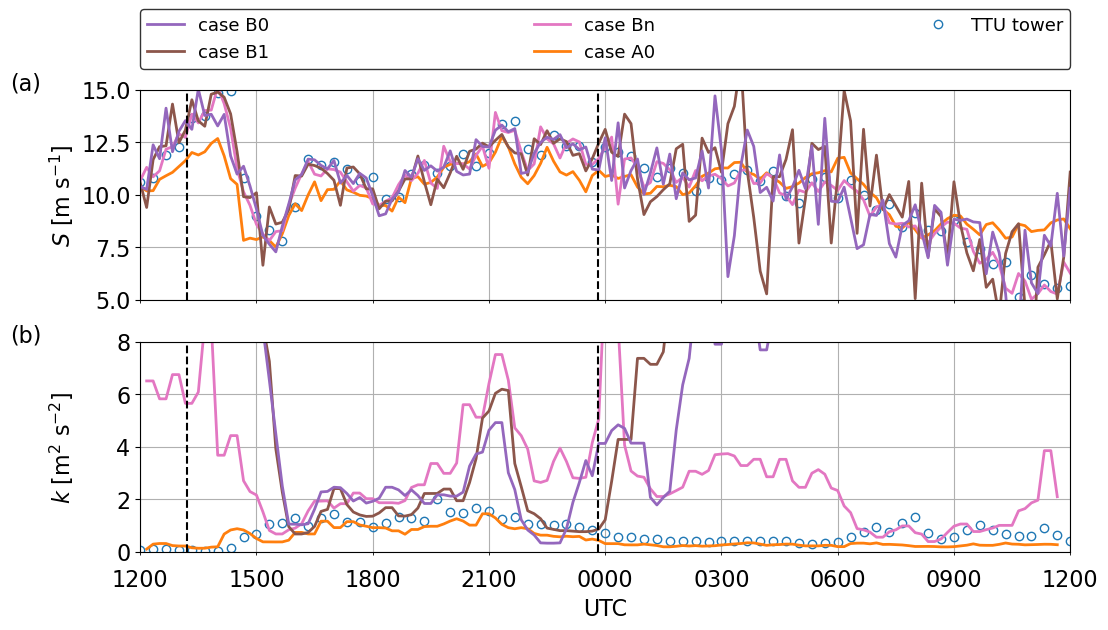

In [18]:
fig,ax = plot_timehistory_at_height(
    datasets={
        'TTU tower': tower_10min,
        **df_10min
    },
    fields = ['wspd','TKEf'],
    heights = hub_height,
    fieldlimits={
        'wspd':(5.,15.),
        'TKEf':(0,8)
    },
    fieldlabels=my_fieldlabels,
    # Specify time limits
    timelimits=('2013-11-08 12:00:00','2013-11-09 12:00:00'),
    # plot local time
    #plot_local_time='%H%M',local_time_offset=-6,
    labelsubplots=True,
    datasetkwargs={
        'TTU tower':{'linestyle':'','marker':'o','mfc':'none','markersize':6,'color':'tab:blue','markevery':2},
        **sim_style
    },
    # Additional keyword arguments to personalize plotting style
    linewidth=2,linestyle='-',marker=None,
)

for axi in ax:
    axi.axvline(pd.to_datetime(sunrise)+ pd.to_timedelta('6h'),color='k',ls='--')
    axi.axvline(pd.to_datetime(sunset)+ pd.to_timedelta('6h'),color='k',ls='--')

#Place legend at the top
handles, labels = ax[0].get_legend_handles_labels()


leg = ax[0].legend(handles[-1::-1],labels[-1::-1],loc='lower left',bbox_to_anchor=(0.0,1.1,1.0,0.0),
             borderaxespad=0,fontsize=13,ncol=3,mode='expand')
leg.get_frame().set_edgecolor('k')

# Adjust xaxis tick locations
ax[-1].xaxis.set_minor_locator(mpl.dates.HourLocator(byhour=range(24),interval=3))
ax[-1].xaxis.set_minor_formatter(mdates.DateFormatter('%H%M'))
ax[-1].xaxis.set_major_locator(mpl.dates.AutoDateLocator(minticks=2,maxticks=3))
ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('\n%m-%d'))

#Move xs tick down slightly to avoid overlap with y ticks in ax[1]
ax[-1].tick_params(axis='x', which='minor', pad=10)
ax[-1].tick_params(axis='x', which='major', pad=10)
ax[-1].set_xticks([])
ax[-1].set_xlabel('UTC')


#Save figure
if save_figures:
    figname = figname_prefix+'_mean_timehistory'
    plt.savefig(os.path.join('Figures',figname+'.png'),bbox_inches='tight')
    plt.savefig(os.path.join('Figures',figname+'.eps'),bbox_inches='tight')
    plt.savefig(os.path.join('Figures',figname+'.pdf'),bbox_inches='tight')

## Figure 6: Mean profiles

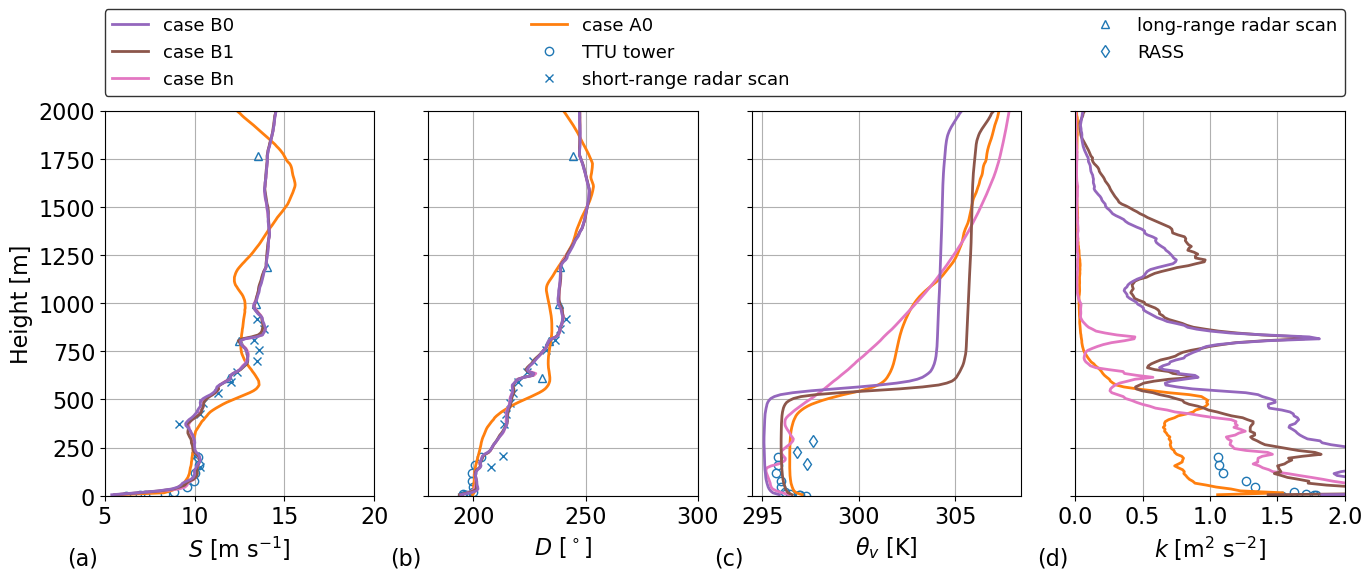

In [19]:
fig,ax = plot_profile(
    datasets={
        'long-range radar scan':radar_scan1_1h,
        'short-range radar scan':radar_scan0_1h,
        'RASS':rass_1h,
        'TTU tower': tower_1h,
        **df_1h
    },
    fields=['wspd','wdir','thetav','TKE'],
    fieldlimits={
        'wspd':(5.,20.),
        'wdir':(180,300),
        'theta':(290,310),
        'TKE':(0,2)
    },
    fieldlabels=my_fieldlabels,
    times=['2013-11-08 18:00:00',],
    # Specify height limits
    heightlimits=(0,2000),
    # Stack results by dataset instead of times
    stack_by_datasets=True,
    # Change field order to have different fields correspond to different columns instead of rows
    fieldorder='F',
    datasetkwargs={'TTU tower':{'linestyle':'','marker':'o','mfc':'none','markersize':6,'color':'tab:blue'},
                   'short-range radar scan':{'linestyle':'','marker':'x','mfc':'none','markersize':6,'color':'tab:blue'},
                   'long-range radar scan':{'linestyle':'','marker':'^','mfc':'none','markersize':6,'color':'tab:blue'},
                   'RASS':{'linestyle':'','marker':'d','mfc':'none','markersize':6,'color':'tab:blue'},
                   **sim_style
                  },
    # Additional keyword arguments to personalize plotting style
    linewidth=2,
    labelsubplots=True,
)

#Place legend at the top
handles, labels = ax[0].get_legend_handles_labels()
Thandles, Tlabels = ax[2].get_legend_handles_labels() # legend entry for Temperature
ax[3].get_legend().remove()

for (handle,label) in zip(Thandles,Tlabels):
    if label not in labels:
        labels.insert(0,label)
        handles.insert(0,handle)


leg = fig.legend(handles[-1::-1], labels[-1::-1], loc = 'lower left', bbox_to_anchor = (.125,.91,.775,0.0),
         borderaxespad=0,ncol=3,fontsize=13,
         bbox_transform = plt.gcf().transFigure,mode='expand')
leg.get_frame().set_edgecolor('k')


#Save figure
if save_figures:
    figname = figname_prefix+'_mean_profiles'
    plt.savefig(os.path.join('Figures',figname+'.png'),bbox_inches='tight')
    plt.savefig(os.path.join('Figures',figname+'.eps'),bbox_inches='tight')
    plt.savefig(os.path.join('Figures',figname+'.pdf'),bbox_inches='tight')